In [1]:
import matplotlib.pyplot as plot
import numpy
from numpy import random
from numpy import dot
from numpy import exp
from numpy import sum
from numpy import log
from numpy import zeros
from numpy import float64
from numpy import int64
from numpy import unravel_index
from numpy import max
from numpy import argmax
from numpy import load
from numpy import array
import pickle
from tabulate import tabulate

Matplotlib is building the font cache; this may take a moment.


In [2]:
def cross_entropy(outputs):
    """
    Fungsi cross entropy untuk mendapatkan nilai loss dari nilai hasil deteksi.

    :param outputs: nilai hasil deteksi.
    :return: nilai loss hasil deteksi.
    """

    loss_value = -log(outputs)

    return loss_value

def relu_activation(summa_nrc):
    """
    Fungsi aktivasi Rectified Linear Unit (ReLU) untuk melakukan aktifasi pada nilai input.

    :param summa_nrc: hasil operasi konvolusi untuk diaktifkan.
    :return: nilai hasil aktivasi ReLU.
    """

    if summa_nrc > 0:
        return summa_nrc
    else:
        return 0

def derivative_relu(summa_nrc):
    """
    Untuk mencari nilai turunan dari fungsi aktivasi ReLU.

    :param summa_nrc: nilai hasil aktivasi ReLU.
    :return: nilai hasil turunan ReLU.
    """

    if summa_nrc > 0:
        return 1
    else:
        return 0


def softmax_activation(summa):
    """
    Fungsi aktivasi softmax untuk melakukan aktivasi nilai dari fully connected layer ke dalam bentuk probabilitas.

    :param summa: nilai pembobotan di fully connected layer.
    :return: nilai hasil aktivasi dalam bentuk probabilitas.
    """

    numerator = exp(summa)
    denominator = sum(numerator)
    softmax_value = numerator / denominator

    return softmax_value

In [3]:
class ConfusionMatrix:
    """
    Kelas untuk membuat confusion matrix dari performa model.

    Attributes:

    actual: 
        label/kelas sebenarnya dari citra.
    result: 
        label/kelas citra hasil deteksi.
    classes: 
        representasi kelas output.
    w_mask:
        representasi kelas tidak bermasker(0).
    mask:
        representasi kelas bermasker(1).
    """

    def __init__(self, actual_class, result_class):

        self.actual = actual_class  # Dalam bentuk array 1D
        self.result = result_class  # Dalam bentuk array 1D
        
        # Classes: 0 (Tidak bermasker), 1 (bermasker)
        self.classes = [0, 1]
        self.w_mask = self.classes[0]
        self.mask = self.classes[1]

    def true_negative(self):
        """
        Fungsi untuk menghitung nilai true negative.

        :returns: nilai true negative.
        """

        actual = self.actual
        result = self.result

        # Nilai awal true negative (tn)
        tn = 0

        for act_, res_ in zip(actual, result):
            if act_ == self.w_mask and res_ == self.w_mask:
                tn += 1
            else: pass

        return tn

    def false_positive(self):
        """
        Fungsi untuk menghitung nilai false positive.

        :returns: nilai false positive.
        """

        actual = self.actual
        result = self.result
        fp = 0

        for act_, res_ in zip(actual, result):
            if act_ == self.w_mask and res_ == self.mask:
                fp += 1
            else: pass

        return fp

    def false_negative(self):
        """
        Fungsi untuk menghitung nilai false negative.

        :returns: nilai false negative.
        """

        actual = self.actual
        result = self.result
        fn = 0

        for act_, res_ in zip(actual, result):
            if act_ == self.mask and res_ ==self.w_mask:
                fn += 1
            else: pass

        return fn

    def true_positive(self):
        """
        Fungsi untuk menghitung nilai true positive.

        :returns: nilai true positive.
        """

        actual = self.actual
        result = self.result
        tp = 0

        for act_, res_ in zip(actual, result):
            if act_ == self.mask and res_ == self.mask:
                tp += 1
            else: pass

        return tp

    def recall(self):
        """
        Fungsi untuk menghitung nilai recall.

        :returns: nilai recall.
        """

        tp = self.true_positive()
        fn = self.false_negative()

        recall = tp / (fn + tp)

        return recall

    def precision(self):
        """
        Fungsi untuk menghitung nilai recall.

        :returns: nilai recall.
        """

        tp = self.true_positive()
        fp = self.false_positive()

        precision = tp / (fp + tp)

        return precision

    def f1_score(self):
        """
        Fungsi untuk menghitung nilai f1-score.

        :returns: nilai f1-score.
        """

        precision = self.precision()
        recall = self.recall()

        f1_score = (2 * precision * recall) / (precision + recall)

        return f1_score

    def display_table(self):
        """
        Fungsi untuk menampilkan visualisasi tabel confusion matrix.

        :returns: tabel confusion matrix.
        """

        tn = self.true_negative()
        fp = self.false_positive()
        fn = self.false_negative()
        tp = self.true_positive()

        header_table = ["Actual/Result", "0", "1"]
        table = [["0", tn, fp], ["1", fn, tp]]
        tformat = "grid"

        return print(tabulate(tabular_data=table, headers=header_table,tablefmt=tformat))

    def accuracy(self):
        """
        Fungsi untuk menghitung nilai accuracy.

        :returns: nilai accuracy.
        """

        actual = self.actual
        result = self.result

        acc_ = 0
        n_data = len(result)

        for act_, res_ in zip(actual, result):
            if act_ == res_:
                acc_ += 1
            else:
                acc_ += 0

        accuracy = acc_ / n_data

        return accuracy

    def model_performance_graph(self):
        """
        Fungsi untuk menampilkan performa model dalam graph bar.

        :returns: graph bar.
        """

        actual = self.actual
        result = self.result

        accuracy = self.accuracy()
        recall = self.recall()
        precision = self.precision()
        f1_score = self.f1_score()

        data = {'accuracy':accuracy, 'racall':recall, 'precision': precision, 'f1_score':f1_score}

        performance = list(data.keys())
        values = list(data.values())

        # creating the bar plot
        plot.figure(figsize = (10, 5))
        plot.bar(performance, values, color ='gray',width = 0.4)
        plot.show()

        return

In [4]:
class Conv2D:
    """
    Kelas untuk membuat convolution layer pertama.
    Satu citra input, dengan kernel 3 dimensi (n_kernel, kernel_size, kernel_size).

    Attributes:
    
    kernel: n-dimensional array.
        kernel yang digunakan pada layer ini.
    bias: 1-dimensional array.
        bias yang digunakan untuk layer ini.
    padding: int.
        jumlah padding yang digunakan di layer ini, nilai default=0.
    stride: int.
        jumlah perpindahan piksel untuk melakukan uperasi konvolusi, nilai default=1.
    """

    def __init__(self, kernel, bias, padding = 0, stride = 1):
        self.kernel = kernel
        self.bias = bias
        self.padding = padding
        self.stride = stride

    def forwardpass(self, image):
        """
        Fungsi untuk convolution layer ini melakukan forwardpass.

        :param image: citra input 2-dimensi (width, height).
        :return: hasil operasi konvolusi yang telah aktivasi relu, berbentuk n-dimensional array.
        """

        # Dapatkan jumlah dan ukuran kernel yang digunakan
        n_kernel, kernel_size, _ = self.kernel.shape

        # Menghitung ukuran output salah satu sisi (width dan height berukuran sama)
        cl_size = int((image.shape[0] - kernel_size + 2 * self.padding) / self.stride) + 1

        # Inisialisasi cl dengan dimensinya, nilai 0 untuk seluruh piksel
        cl = zeros((n_kernel, cl_size, cl_size), dtype=float64)

        # Inisialisasi output turunan fungsi relu, nilai 0 seluruh piksel
        d_cl_summa = zeros(cl.shape, dtype=float64)

        for nk in range(n_kernel):
            for row in range(cl_size):
                for col in range(cl_size):
                    # Mendapatkan lokasi region untuk operasi konvolusi
                    local_region = image[row:(row + kernel_size), col:(col + kernel_size)]

                    # Operasi konvolusi
                    summa_nrc = sum(local_region * self.kernel[nk]) + self.bias[nk]

                    # Operasi aktivasi relu
                    cl[nk, row, col] = relu_activation(summa_nrc)

                    # Operasi turunan relu
                    d_cl_summa[nk, row, col] = derivative_relu(cl[nk, row, col])

        return cl, d_cl_summa

In [5]:
class Conv3D:
    """
    Kelas untuk membuat convolution layer kedua dan seterusnya.
    Dua atau lebih citra input, dengan kernel 3 dimensi (n_kernel, kernel_size, kernel_size).

    Attributes:
    
    kernel: n-dimensional array.
        Kernel yang digunakan pada layer ini.
    bias: 1-dimensional array.
        bias yang digunakan untuk layer ini.
    padding: int.
        jumlah padding yang digunakan di layer ini, nilai default=0.
    stride: int.
        jumlah perpindahan piksel untuk melakukan uperasi konvolusi, nilai default=1.
    """

    def __init__(self, kernel, bias, padding=0, stride=1):
        self.kernel = kernel
        self.bias = bias
        self.padding = padding
        self.stride = stride

    def forwardpass(self, pl):
        """
        Fungsi untuk convolutional layer ini melakukan forwardpass.

        :param pl: Hasil operasi pooling sebelumnya.
        :return: Hasil operasi konvolusi yang telah diaktifasi relu, berbentuk n-dimensional array.
        """

        # Mendapatkan jumlah kernel sekarang, sebelumnya, dan ukuran kernel dari dimensi kernel yang digunakan saat ini
        n_kernel_current, n_kernel_prev, kernel_size, _ = self.kernel.shape

        # Menghitung ukuran output salah satu sisi (width dan height berukuran sama)
        cl_size = int((pl.shape[1] - kernel_size + 2 * self.padding) / self.stride) + 1

        # Inisialisasi cl dan memberikan nilai 0 untuk seluruh piksel
        cl = zeros((n_kernel_current, cl_size, cl_size), dtype=float64)

        # Inisialisasi output turunan aktivasi relu dan memberikan nilai 0
        d_cl_summa = zeros(cl.shape, dtype=float64)

        d_summa_pl = zeros(pl.shape + cl.shape, dtype=float64)

        for nkc in range(n_kernel_current):
            for row in range(cl_size):
                for col in range(cl_size):
                    # Mendapatkan lokasi region untuk operasi konvolusi
                    local_region = pl[0:n_kernel_prev, row:(row + kernel_size), col:(col + kernel_size)]
                    # Operasi konvolusi
                    summa_nrc = sum(local_region * self.kernel[nkc]) + self.bias[nkc]
                    # Operasi aktivasi
                    cl[nkc, row, col] = relu_activation(summa_nrc)
                    # Operasi turunan aktivasi
                    d_cl_summa[nkc, row, col] = derivative_relu(cl[nkc, row, col])
                    d_summa_pl[0:n_kernel_prev, row:(row + kernel_size), col:(col + kernel_size),nkc ,row, col] = self.kernel[nkc]

        return cl, d_cl_summa, d_summa_pl

In [6]:
class MaxPool:
    """
    Kelas untuk membuat pooling layer dengan operasi max pooling. Jumlah citra input dan output sama.

    Attribute:
    
    pool_size: int
        Ukuran pooling yang digunakan, bernilai default=2 yang berarti array 2 x 2.

    """

    def __init__(self, pool_size=2):
        self.pool_size = pool_size

    def forwardpass(self, cl):
        """
        Fungsi untuk pooling layer melakukan forwardpass.

        :param cl: Hasil convolutional layer sebelumnya.
        :return: Hasil operasi pooling dan lokasi indeks dari operasi pooling.
        """

        # Mendapatkan jumlah kernel dan ukuran kernel dari dimensi output conv layer sebelumnya
        n_kernel, cl_size, _ = cl.shape
        pl_size = int(cl_size / self.pool_size)

        pl = zeros((n_kernel, pl_size, pl_size), dtype=float64)
        index_loc = zeros((n_kernel, pl_size, pl_size), dtype=(int64, 2))

        for nk in range(n_kernel):
            for row in range(pl_size):
                for col in range(pl_size):
                    local_region = cl[nk,(2 * row):(2 * row + 2),(2 * col):(2 * col + 2)]
                    pl[nk, row, col] = max(local_region)
                    local_index = unravel_index(argmax(local_region), local_region.shape)
                    index_loc[nk, row, col] = [2 * row + local_index[0], 2 * col + local_index[1]]

        return pl, index_loc

In [7]:
class ConvNet:
    """
    Kelas untuk membuat arsitektur ConvNet.
    """

    def __init__(self, n_kernel_1, n_kernel_2, n_kernel_3):
        # Ukuran kernel (width dan height sama, diambil salah satu
        KERNEL_SIZE = 5
        # Batas minimum
        MIN = -0.1
        # Batas maksimum
        MAX = 0.1
        # Banyak piksel (pl width x pl height) setelah flatten di fully connected layer
        FLATTEN_PIXELS = 16
        N_OUTPUTS = 2

        # Inisialisasi kernel dan bias convolution layer 1
        self.kernel_1 = random.uniform(low=MIN, high=MAX, size=(n_kernel_1, KERNEL_SIZE, KERNEL_SIZE))
        self.bias_1 = random.uniform(low=MIN, high=MAX, size=n_kernel_1)

        # Inisialisasi kernel dan bias convolution layer 2
        self.kernel_2 = random.uniform(low=MIN, high=MAX, size=(n_kernel_2, n_kernel_1, KERNEL_SIZE, KERNEL_SIZE))
        self.bias_2 = random.uniform(low=MIN, high=MAX, size=n_kernel_2)

        # Inisialisasi kernel dan bias convolution layer 3
        self.kernel_3 = random.uniform(low=MIN, high=MAX, size=(n_kernel_3, n_kernel_2, KERNEL_SIZE, KERNEL_SIZE))
        self.bias_3 = random.uniform(low=MIN, high=MAX, size=n_kernel_3)

        # Inisialisasi weight(bobot) dan bias fully connected layer
        self.weight = random.uniform(low=MIN, high=MAX, size=(N_OUTPUTS, n_kernel_3 * FLATTEN_PIXELS))
        self.bias = random.uniform(low=MIN, high=MAX, size=N_OUTPUTS)

    def forwardpass(self, image):
        """
        Fungsi untuk melakukan forwardpass.

        :param image: citra input.
        :return: citra dengan n-dimesional.

        """

        # Convolution layer 1
        conv_layer_1 = Conv2D(self.kernel_1, self.bias_1, padding=0, stride=1)
        cl1, d_cl1_sum1 = conv_layer_1.forwardpass(image)

        # Pooling layer 1
        pool_layer_1 = MaxPool(pool_size=2)
        pl1, index_loc1 = pool_layer_1.forwardpass(cl1)

        # Convolution layer 2
        conv_layer_2 = Conv3D(self.kernel_2, self.bias_2, padding=0, stride=1)
        cl2, d_cl2_sum2, d_sum2_pl1 = conv_layer_2.forwardpass(pl1)

        # Pooling layer 2
        pool_layer_2 = MaxPool(pool_size=2)
        pl2, index_loc2 = pool_layer_2.forwardpass(cl2)

        # Convolution layer 3
        conv_layer_3 = Conv3D(self.kernel_3, self.bias_3, padding=0, stride=1)
        cl3, d_cl3_sum3, d_sum3_pl2 = conv_layer_3.forwardpass(pl2)

        # Pooling layer 3
        pool_layer_3 = MaxPool(pool_size=2)
        pl3, index_loc3 = pool_layer_3.forwardpass(cl3)

        # Fully Connected layer
        # Merubah jadi 1 dimensi (n, dim1, dim2) -> n images (dim1)
        flattens = pl3.flatten()
        # Penjumlahah dari perkalian pembobotan
        summa = dot(self.weight, flattens) + self.bias
        # Class 0 dan 1 , outputs [0, 1]
        outputs = softmax_activation(summa)

        return flattens, outputs
    
    def testing(self, images_testing, labels_testing):
        """
        Fungsi untuk melakukan pengujian data.

        :param images_testing: data citra uji.
        :param labels_testing: data label dari citra uji.
        :return: 

        """

        len_perm = random.permutation(len(images_testing))

        images = images_testing[len_perm]
        labels = labels_testing[len_perm]

        test_loss_values = []
        test_average_loss = []
        output = []
        result_class =[]

        counter_img = 0

        print("Pengujian data: ")

        for image, label in zip(images, labels):
            flattens, outputs = self.forwardpass(image)
            test_loss_values.append(cross_entropy(outputs[label]))

            output.append(outputs)

            identify_image = argmax(outputs)
            result_class.append(identify_image)

            counter_img += 1
            print("Data ke-{}: kelas sebenarnya {}, diidentifikasi sebagai kelas {}, dengan hasil {}.".format(counter_img, label, identify_image , str(outputs)))

        # Calculate loss
        test_loss_values = array(test_loss_values)
        test_average_loss.append(test_loss_values.mean())

        saved_outputs = array(output)
        actual_class = array(labels)
        result_class = array(result_class)

        print("Nilai rata-rata loss {}.".format(test_loss_values.mean()))

        return test_average_loss, saved_outputs, actual_class, result_class
        

In [9]:
numpy.set_printoptions(edgeitems=1000, linewidth=100000)

# Testing data
mfid_image_testing = load("data/test_mfid_images.npy")
images_testing = (mfid_image_testing/255)-0.5
labels_testing = load("data/test_mfid_labels.npy")

# Load
with open("trained-model/d_model.bin", "rb") as d_mod:
    ConvNet_D = pickle.load(d_mod)

testing = ConvNet_D.testing(images_testing, labels_testing)
test_average_loss = testing[0]
outputs = testing[1]
actual_class = testing[2]
result_class = testing[3]

Pengujian data: 
Data ke-1: kelas sebenarnya 0, diidentifikasi sebagai kelas 0, dengan hasil [9.99266086e-01 7.33914498e-04].
Data ke-2: kelas sebenarnya 0, diidentifikasi sebagai kelas 0, dengan hasil [9.99999991e-01 9.35173087e-09].
Data ke-3: kelas sebenarnya 0, diidentifikasi sebagai kelas 0, dengan hasil [9.99978802e-01 2.11978269e-05].
Data ke-4: kelas sebenarnya 0, diidentifikasi sebagai kelas 0, dengan hasil [9.99998955e-01 1.04515033e-06].
Data ke-5: kelas sebenarnya 1, diidentifikasi sebagai kelas 1, dengan hasil [6.63153425e-05 9.99933685e-01].
Data ke-6: kelas sebenarnya 1, diidentifikasi sebagai kelas 1, dengan hasil [0.00187438 0.99812562].
Data ke-7: kelas sebenarnya 1, diidentifikasi sebagai kelas 1, dengan hasil [1.00315740e-06 9.99998997e-01].
Data ke-8: kelas sebenarnya 0, diidentifikasi sebagai kelas 0, dengan hasil [9.99418539e-01 5.81461186e-04].
Data ke-9: kelas sebenarnya 0, diidentifikasi sebagai kelas 0, dengan hasil [0.9790368 0.0209632].
Data ke-10: kelas se

+-----------------+-----+-----+
|   Actual/Result |   0 |   1 |
+=================+=====+=====+
|               0 | 731 |  38 |
+-----------------+-----+-----+
|               1 |  26 | 555 |
+-----------------+-----+-----+
Accuracy: 0.95259259
Precision: 0.93591906
Recall: 0.95524957
F1-Score: 0.94548552


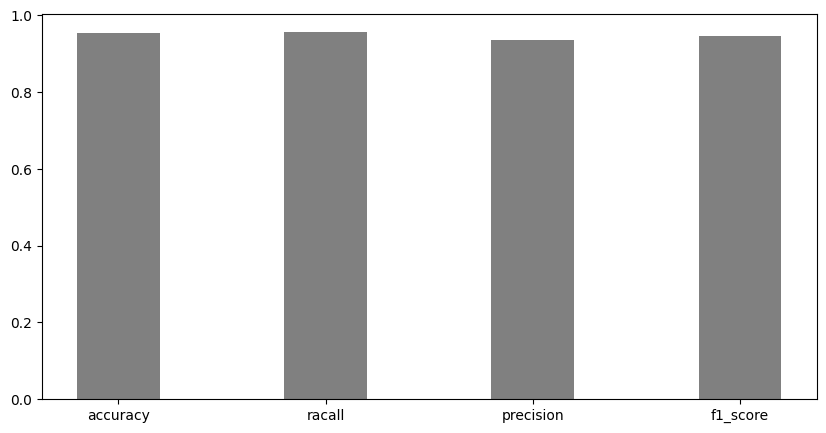

In [10]:
CM_ModD = ConfusionMatrix(actual_class, result_class)

CM_ModD.display_table()

print("Accuracy: {:02.8f}".format(CM_ModD.accuracy()))
print("Precision: {:02.8f}".format(CM_ModD.precision()))
print("Recall: {:02.8f}".format(CM_ModD.recall()))
print("F1-Score: {:02.8f}".format(CM_ModD.f1_score()))

CM_ModD.model_performance_graph()